## Importing modules and packages

In [121]:
# Importing packages
import pandas as pd
import numpy  as np
import folium
import os.path
import shapely
import branca.colormap as cm
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib.patheffects as PathEffects

# Importing modules
import gr_mapmatch # Contains functions that perform the map matching of roads
import gr_placematch # Contains functions that perform the map matching of places
import gr_utils # Contains useful geometry functions
import gr_plot # Contains plotting routines
import gr_process

## Input parameters

In [172]:
# Name of the hiking trail to be considered (will search for trail.csv or trail.gpx as sources)
# trailname = 'gr122'
# trailname = 'gr131'
trailname = 'gr564'
d_per_plot = 25 # distance covered by each suplot [km]
d_limit_city = 250 # minimum distance that the route must traverse through a city for it to be considered [m]

## Loading data

In [173]:
trail = gr_utils.get_gpx(trailname)
data = gr_utils.read_processed(trailname)
data.reset_index(inplace = True, drop = True)

Loading trail points from <data_input/gr564.gpx>...
Finished loading.


In [174]:
# Settings for places2processed
tol_d        = 0.75 # Consider a segment developed if it lies closer than tol_d to a developed area
# tol_d        = 0.50 # Consider a segment developed if it lies closer than tol_d to a developed area
tracktype_p0 = ['grade4','grade5']
tracktype_p1 = ['grade2','grade3']
tracktype_p2 = ['grade1']
surface_p0   = ['ground','grass','dirt','sand','earth','mud']
surface_p1   = ['unpaved','gravel','fine_gravel','wood','compacted','rocks','pebblestone','woodchips','snow','ice','salt']
highway_p1   = ['track','path','footway','bridleway']
types_slow   = ['pedestrian','track','footway','bridleway','steps','corridor','path']
types_heavy  = ['motorway','trunk','primary','secondary','tertiary']
trail = gr_utils.get_gpx(trailname)
filename_places = 'cache/' + trailname + '_places.csv'
data_places = gr_utils.read_places(trailname) # Read the merged PLACES file
data_places2 = gr_mapmatch.remove_repeat_segments(data_places) # Remove backtracked sections
data = gr_process.places2processed(data_places2,tol_d,types_slow,types_heavy,tracktype_p0,tracktype_p1,tracktype_p2,surface_p0,surface_p1,highway_p1) # Determine traffic/development/paved status & GR types
data.reset_index(inplace = True, drop = True)

Loading trail points from <data_input/gr564.gpx>...
Finished loading.


## Calculations

In [175]:
# Calculating focus point
focus = gr_plot.get_focus(trail)

In [176]:
# Cumulative distance at start and end point of each segment
data = gr_process.calculate_cumulative_distances(data)

In [177]:
# Group segments by development status
devgroups = gr_process.get_development_groups(data)

In [178]:
# Smoothing development status (any groups with dev=1 but length<250m are set to dev=0)
for idx, row in devgroups.iterrows():
    j0 = row['j0']
    j1 = row['j1']
#     data_subset = data.loc[j0:j1+1]
    if row['dev']==0: # smoothed dev = 
        data.loc[j0:j1,'smoothed_development'] = 0
    else: # check the length
        if row['d']<d_limit_city: # then override to dev=0
            data.loc[j0:j1,'smoothed_development'] = 0
        else: # keep the original value
            data.loc[j0:j1,'smoothed_development'] = data.loc[j0:j1,'development']
data['development'] = data['smoothed_development']

In [179]:
# Miscellaneous
d_max = data.tail(1)['d0'].values.tolist()[0] # Total distance of the route
n_points = data.shape[0] # Number of segments in the route
n_plots = int(np.ceil(d_max/(d_per_plot*1000))) # Number of sections plots we will make

In [180]:
# Overall percentages of paved/traffic/development
dist = data['d_cart'].sum()
# Paved types
perc_p0 = data[data['paved']==0]['d_cart'].sum()/dist
perc_p1 = data[data['paved']==1]['d_cart'].sum()/dist
perc_p2 = data[data['paved']==2]['d_cart'].sum()/dist
# Traffic types
perc_t0 = data[data['traffic']==0]['d_cart'].sum()/dist
perc_t1 = data[data['traffic']==1]['d_cart'].sum()/dist
perc_t2 = data[data['traffic']==2]['d_cart'].sum()/dist
# Development types
perc_d0 = data[data['development']==0]['d_cart'].sum()/dist
perc_d1 = data[data['development']==1]['d_cart'].sum()/dist
# Merging
overall_stats = pd.DataFrame({'dist':[dist],
                              'perc_p0':[perc_p0],'perc_p1':[perc_p1],'perc_p2':[perc_p2],
                              'perc_t0':[perc_t0],'perc_t1':[perc_t1],'perc_t2':[perc_t2],
                              'perc_d0':[perc_d0],'perc_d1':[perc_d1]})

In [181]:
# Percentages of paved/traffic/development for the different sections
stats = pd.DataFrame({'i0':[],'i1':[],'dist':[],'perc_p0':[],'perc_p1':[],'perc_p2':[],'perc_t0':[],'perc_t1':[],'perc_t2':[],'perc_d0':[],'perc_d1':[]})
for k in range(n_plots):
    # Indices
    i0 = data[data['d0'].gt(k*d_per_plot*1000)].index[0]
    i1_temp = data[data['d0'].gt((k+1)*d_per_plot*1000)]
    if i1_temp.shape[0]>0:
        i1 = i1_temp.index[0]
    else:
        i1 = n_points
    # Grabbing data subset
    subset = data.loc[i0:i1]
    delta_d = subset['d_cart'].sum()
    # Paved types
    perc_p0 = subset[subset['paved']==0]['d_cart'].sum()/delta_d
    perc_p1 = subset[subset['paved']==1]['d_cart'].sum()/delta_d
    perc_p2 = subset[subset['paved']==2]['d_cart'].sum()/delta_d
    # Traffic types
    perc_t0 = subset[subset['traffic']==0]['d_cart'].sum()/delta_d
    perc_t1 = subset[subset['traffic']==1]['d_cart'].sum()/delta_d
    perc_t2 = subset[subset['traffic']==2]['d_cart'].sum()/delta_d
    # Development types
    perc_d0 = subset[subset['development']==0]['d_cart'].sum()/delta_d
    perc_d1 = subset[subset['development']==1]['d_cart'].sum()/delta_d
    # Merging
    section = {'i0':i0, 'i1':i1, 'dist':delta_d,
               'perc_p0':perc_p0, 'perc_p1':perc_p1, 'perc_p2':perc_p2,
               'perc_t0':perc_t0, 'perc_t1':perc_t1, 'perc_t2':perc_t2,
               'perc_d0':perc_d0, 'perc_d1':perc_d1}
    stats = pd.concat([stats, pd.DataFrame([section],index=[k])])

In [182]:
# List of main cities traversed by the route
unique_cities = data['city'].unique().tolist() # All cities
selected_cities = []
# Selecting the cities that will be shown
for city in unique_cities:
    subset = data[data['city']==city]
    if subset['d_cart'].sum() > d_limit_city:
        selected_cities.append(city)
# Find the mediam km mark at which each city occurs
city_locations = []
for city in selected_cities:
    subset = data[data['city']==city]
    indices = subset.index.tolist()
    index_median = indices[int(np.round(len(indices)/2))]
    city_locations.append(np.round(data.loc[index_median,'d0'])/1000) # km at which the middle occurrence of that city is

## Summarizing statistics

In [183]:
stats_merged = pd.concat([overall_stats,stats],ignore_index=True)

In [184]:
def add_row(df,new_section,new_category,new_type,new_percentage):
    newrow = {'section':new_section,
              'category':new_category,
              'type':new_type,
              'perc':new_percentage}
    df = pd.concat([df, pd.DataFrame([newrow])])
    return df

In [185]:
df = pd.DataFrame(pd.DataFrame({'section':[],'category':[],'perc':[],'type':[]}))
for idx, row in stats_merged.iterrows():
    if idx==0:
        section_name = 'Overall'
    else:
        km_start = (idx-1)*d_per_plot
        km_end = idx*d_per_plot
        section_name = f'#{idx}: {km_start}-{km_end} km'
    # Paved
    df = add_row(df,section_name,'paved',0,100*row['perc_p0'])
    df = add_row(df,section_name,'paved',1,100*row['perc_p1'])
    df = add_row(df,section_name,'paved',2,100*row['perc_p2'])
    # Traffic
    df = add_row(df,section_name,'traffic',0,100*row['perc_t0'])
    df = add_row(df,section_name,'traffic',1,100*row['perc_t1'])
    df = add_row(df,section_name,'traffic',2,100*row['perc_t2'])
    # Development
    df = add_row(df,section_name,'development',0,100*row['perc_d0'])
    df = add_row(df,section_name,'development',2,100*row['perc_d1'])

In [186]:
alt.Chart(df).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('category:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(perc):Q',
            axis=alt.Axis(
            grid=True,
            title="Percentage coverage",
            values=[0, 25, 50, 75, 100]
            ),
            scale=alt.Scale(domain=[0, 100]),),

    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('section:N', title=f'Analysis of {trailname.upper()}', header=alt.Header(titleFontSize=20)),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('type:N',scale=alt.Scale(range=['#96ceb4', '#ffcc5c','#ff6f69'],),),opacity=alt.value(0.7)
).configure_view(strokeOpacity=0
).configure_axis(labelFontSize=12,titleFontSize=1
).properties(width=80,height=250
).configure_header(labelFontSize=12,labelFontWeight='bold')

alt.Chart(...)

## Rendering section plots

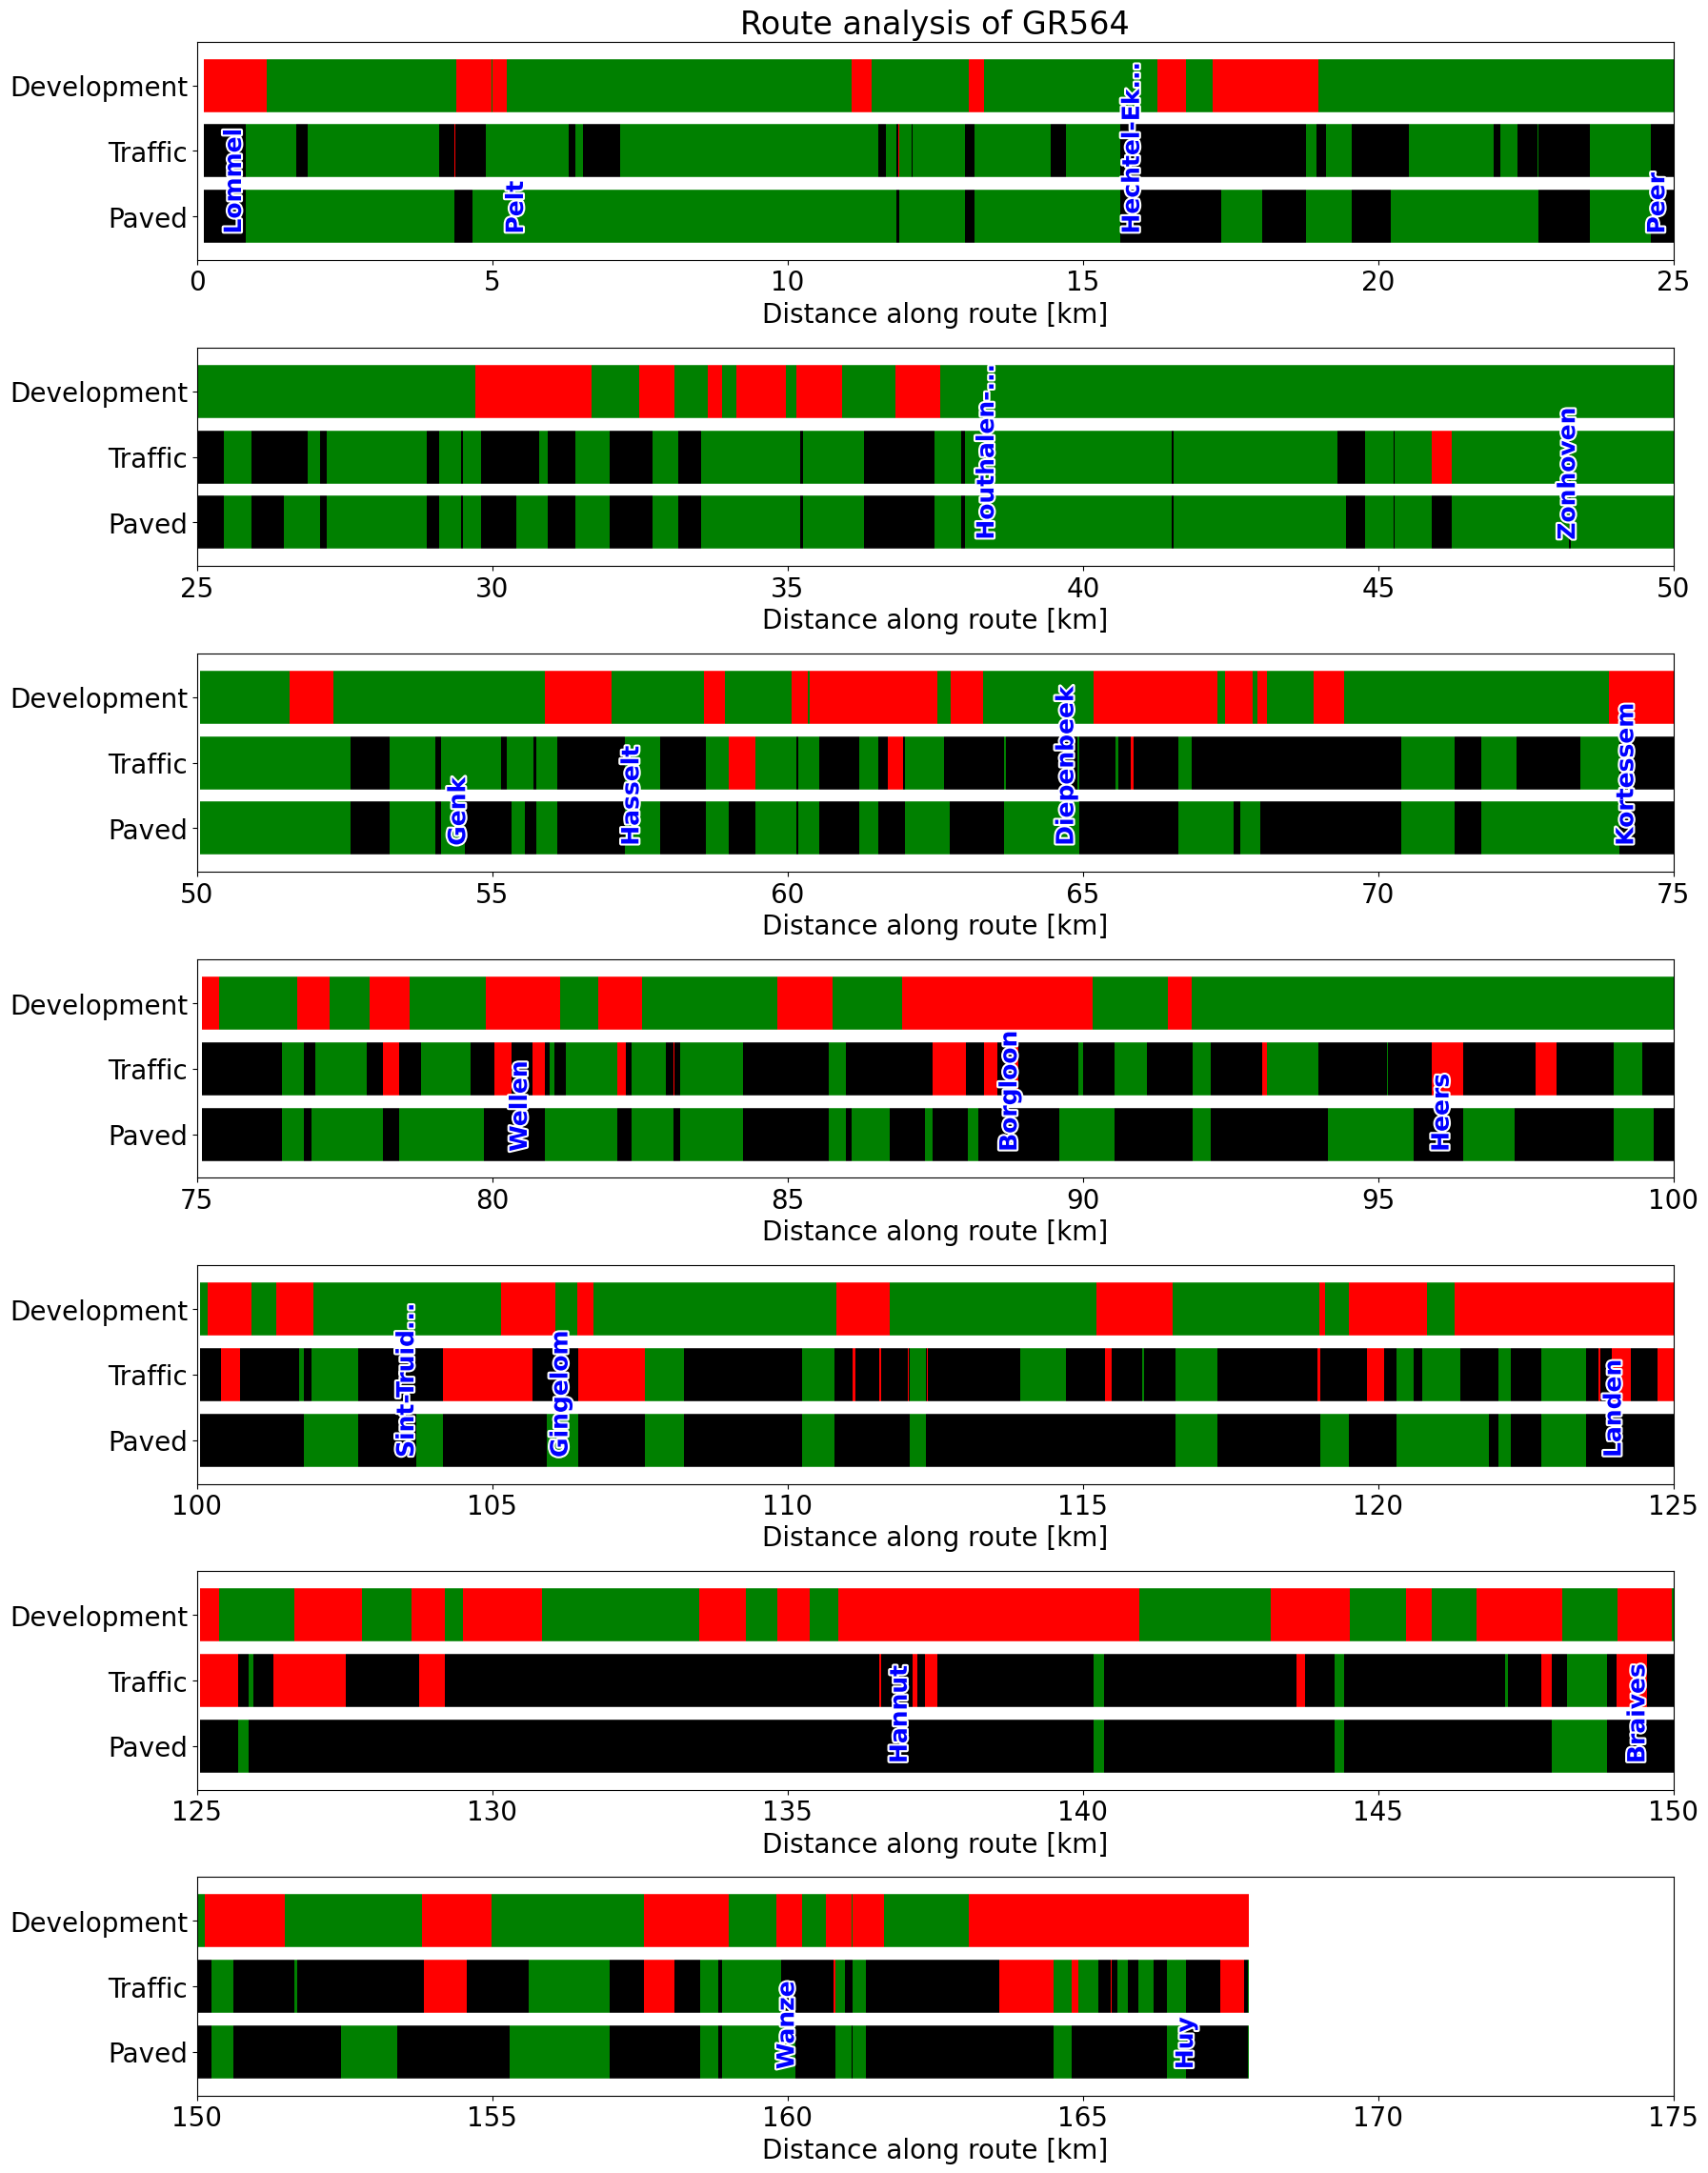

In [187]:
# Sections with paved/traffic/development types
fig, ax = plt.subplots(n_plots,1,figsize=(20,4*n_plots))
plt.rc('font', size=20)
lw = 40
for k in range(n_plots):
    
    # Indices of the subset
    i0 = int(stats.iloc[k]['i0']) # start index
    i1 = int(stats.iloc[k]['i1']) # end index
    
    # Drawing paved/traffic/development types
    for i in range(i0,i1):
        
        # Coordinates
        x = [data.loc[i,'d0']/1000,data.loc[i,'d1']/1000]
        y_paved = [0.85,0.85]
        y_traffic = [1.0,1.0]
        y_development = [1.15,1.15]
        
        # Drawing paved type
        if data.loc[i,'paved']==2: # Draw paved as black
            ax[k].plot(x,y_paved,linewidth=lw,color='black',solid_capstyle='butt',alpha=1)
        else: # Draw unpaved and semi-paved as green
            ax[k].plot(x,y_paved,linewidth=lw,color='green',solid_capstyle='butt',alpha=1)
            
        # Drawing traffic type
        if data.loc[i,'traffic']==0: # Draw slow road as green
            ax[k].plot(x,y_traffic,linewidth=lw,color='green',solid_capstyle='butt',alpha=1)
        elif data.loc[i,'traffic']==1: # Draw normal road as black
            ax[k].plot(x,y_traffic,linewidth=lw,color='black',solid_capstyle='butt',alpha=1)
        else: # Draw busy road as red
            ax[k].plot(x,y_traffic,linewidth=lw,color='red',solid_capstyle='butt',alpha=1)
            
        # Drawing development type
        if data.loc[i,'development']==0: # Draw undeveloped as green
            ax[k].plot(x,y_development,linewidth=lw,color='green',solid_capstyle='butt',alpha=1)
        else: # Draw developed as red
            ax[k].plot(x,y_development,linewidth=lw,color='red',solid_capstyle='butt',alpha=1)
    
    # Writing city names
    for j in range(len(selected_cities)):
        thisd = city_locations[j]
        if thisd>k*d_per_plot and thisd<(k+1)*d_per_plot:
            lmax = 10
            if len(selected_cities[j])>lmax:
                cityname = selected_cities[j][0:lmax] + '...'
            else:
                cityname = selected_cities[j]
            txt = ax[k].text(thisd, 0.81, cityname, rotation=90, fontsize=18, color='blue', wrap=True, fontweight='bold')
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
    
    # Configuring plot
    ax[k].set_xlim(k*d_per_plot, (k+1)*d_per_plot)
    ax[k].set_ylim(0.75, 1.25)
    ax[k].set_yticks([0.85, 1.0, 1.15],labels=['Paved','Traffic','Development'])
    ax[k].set_xlabel('Distance along route [km]')
    if k==0:
        ax[k].set_title(f'Route analysis of {trailname.upper()}')
    
plt.subplots_adjust(hspace=0.4)
plt.show()

In [188]:
def row2type_smoothed(row):
    
    types_light = [[1,1,4],[1,1,6],[3,3,3]]
    types_heavy = [[2,2,4],[2,2,5],[3,3,3]]
    
    if row['smoothed_development']==0: # light
        gr_type = types_light[row['traffic']][row['paved']]
    else: # heavy
        gr_type = types_heavy[row['traffic']][row['paved']]
    
    return gr_type

In [189]:
def get_gr_type_smoothed(data):
    
    data['gr_type'] = data.apply(row2type_smoothed, axis=1)
    return data

In [190]:
data = get_gr_type_smoothed(data)

## Rendering maps

In [191]:
# # Compare GPX points with fitted route
trail_coords = gr_mapmatch.trail_to_coords(trail)
filepath = gr_plot.compare_tracks(trailname,trail_coords,data)
IFrame(filepath, width=1000, height=500)

In [192]:
# Plotting RAW development type with groups
# filepath = gr_plot.show_raw_development(trailname,data,devgroups,focus)
 
# Prepare data to be plotted
colors = data['development'].values.tolist()
x = data['x0'].values.tolist()
y = data['y0'].values.tolist()
x.extend(data.tail(1)['x1'])
y.extend(data.tail(1)['y1'])
xy0 = list(zip(x,y))
xy = [[coord[0],coord[1]] for coord in xy0]

# Colormap setup
colormap = cm.LinearColormap(colors=['#21ce2c','red'],vmin=0.25,vmax=0.75,index=[0.25,0.75])

# Map setup
chart = folium.Map(location=focus, zoom_start=11, tiles="OpenStreetMap")

for idx, group in devgroups.iterrows():
    j0 = int(group['j0'])
    j1 = int(group['j1'])
    if data.loc[j0]['development']==0:
        c = 'green'
    else:
        c = 'red'
    d = np.round(group['d'])
    newline = folium.PolyLine(locations=xy[j0:j1+2], color=c, weight=3, popup=str(d))
    newline.add_to(chart)

# Render the map
filepath = f"cache/{trailname}_development_raw.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

In [193]:
# Plotting SMOOTHED development type with groups
# filepath = gr_plot.show_raw_development(trailname,data,devgroups,focus)
 
# Prepare data to be plotted
colors = data['smoothed_development'].values.tolist()
x = data['x0'].values.tolist()
y = data['y0'].values.tolist()
x.extend(data.tail(1)['x1'])
y.extend(data.tail(1)['y1'])
xy0 = list(zip(x,y))
xy = [[coord[0],coord[1]] for coord in xy0]

# Colormap setup
colormap = cm.LinearColormap(colors=['#21ce2c','red'],vmin=0.25,vmax=0.75,index=[0.25,0.75])

# Map setup
chart = folium.Map(location=focus, zoom_start=11, tiles="OpenStreetMap")

for idx, group in devgroups.iterrows():
    j0 = int(group['j0'])
    j1 = int(group['j1'])
    if data.loc[j0]['smoothed_development']==0:
        c = 'green'
    else:
        c = 'red'
    d = np.round(group['d'])
    newline = folium.PolyLine(locations=xy[j0:j1+2], color=c, weight=3, popup=str(d))
    newline.add_to(chart)

# Render the map
filepath = f"cache/{trailname}_development_smoothed.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

In [194]:
# Plotting traffic type
filepath = gr_plot.show_traffic(trailname,data,focus)
IFrame(filepath, width=1000, height=500)

In [195]:
# Plotting paved type with highway/surface/tracktype labels
filepath = gr_plot.show_paved_detail(trailname,data,focus)
IFrame(filepath, width=1000, height=500)

In [196]:
# Plotting GR type with highway/surface/tracktype labels
filepath = gr_plot.show_type_detail(trailname,data,focus)
IFrame(filepath, width=1000, height=500)